<em> Code for Section 4.1, <b>1D Search Space Simulation</b> </em>

In [20]:
# Imports

import torch
import numpy as np
import matplotlib.pyplot as plt
import pyDOE

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood, SumMarginalLogLikelihood
from botorch.acquisition import LogExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.acquisition.analytic import LogConstrainedExpectedImprovement
from botorch.models.model_list_gp_regression import ModelListGP

from matplotlib import colormaps

Plotting the Salustowicz function

In [21]:
# Defining the function for simple plotting

def objective_function(x):
    return -torch.exp(-x) * x**3 * torch.cos(x) * torch.sin(x) * (torch.cos(x) * torch.sin(x)**2 - 1) # Salustowicz

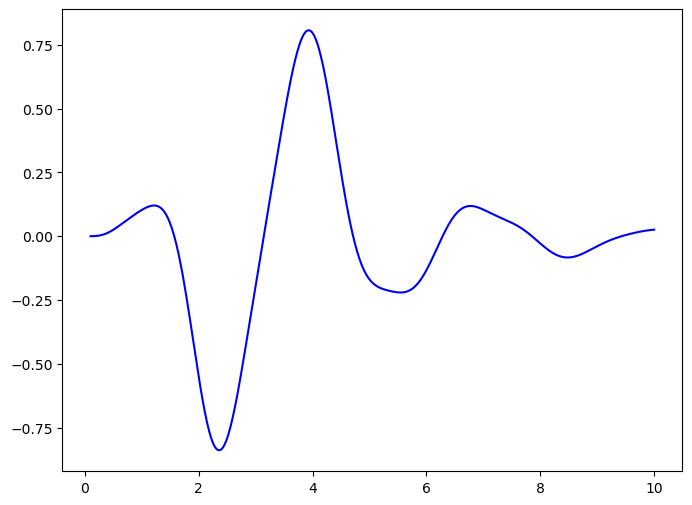

In [22]:
# Plotting

x = torch.linspace(0.1, 10, 500) 

y = objective_function(x)

x_np = x.numpy()
y_np = y.numpy()

# Plot the function
plt.figure(figsize=(8, 6))
plt.plot(x_np, y_np, label='Salustowicz Function', color='blue')
plt.show()

4.1.1 Progress of Unconstrained Bayesian Optimisation

In [23]:
# Suppress warnings 

import warnings
from botorch.exceptions import InputDataWarning, OptimizationWarning

warnings.filterwarnings("ignore", category=InputDataWarning)

warnings.filterwarnings("ignore", category=OptimizationWarning)

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [38]:
# Latin Hypercube Sampling 

def latin_hypercube_sampling(n_samples, dim, bounds):
    lhs_samples = pyDOE.lhs(dim, samples=n_samples)
    lhs_samples = np.clip(lhs_samples, 0, 1)
    bounds_np = np.array(bounds)
    scaled_samples = lhs_samples * (bounds_np[1] - bounds_np[0]) + bounds_np[0]

    return torch.tensor(scaled_samples, dtype=torch.float64)

In [40]:
# Define the objective

def objective_function(x):
    return -torch.exp(-x[..., 0]) * x[..., 0]**3 * torch.cos(x[..., 0]) * torch.sin(x[..., 0]) * (torch.cos(x[..., 0]) * torch.sin(x[..., 0])**2 - 1) # Salustowicz

In [41]:
# Setting up the plot

def plot_bayesian_optimization(ax, train_X, train_Y, model, X, Y, iteration=None):
  
    ax.plot(X.numpy(), Y, 'b-', linewidth=1, label='Objective')
    
    # Predict mean and variance for entire range
    with torch.no_grad():
        posterior = model.posterior(X)
        mean = posterior.mean.numpy()
        std = posterior.variance.sqrt().numpy()
    
    # Plot GP mean prediction
    ax.plot(X.numpy(), mean, 'g--', linewidth=1, label='GP Mean')
    
    # Plot GP uncertainty 
    ax.fill_between(
        X.numpy().flatten(), 
        mean.flatten() - 2*std.flatten(), 
        mean.flatten() + 2*std.flatten(), 
        alpha=0.3, 
        color='green'
    )
    
    # Plot evaluated points
    ax.scatter(
        train_X.numpy(), 
        train_Y.numpy(), 
        color='red', 
        edgecolor='black',
        marker='o', 
        s=20  
    )
    
    # Find and plot the best point with a white star
    best_idx = torch.argmax(train_Y)
    best_x = train_X[best_idx]
    best_y = train_Y[best_idx]
    ax.scatter(
        best_x.numpy(), 
        best_y.numpy(), 
        color='white', 
        edgecolor='black', 
        marker='*', 
        s=100, 
        zorder=10 
    )
    
    if iteration is not None:
        ax.set_title(f'Iteration {iteration}', fontsize=10, fontweight='bold')
    
    ax.tick_params(axis='both', which='major', labelsize=6)

Iteration 1: Best value so far: 0.4205169975757599
Iteration 2: Best value so far: 0.5455319881439209
Iteration 3: Best value so far: 0.7103824615478516
Iteration 4: Best value so far: 0.8055709600448608
Iteration 5: Best value so far: 0.8055709600448608
Iteration 6: Best value so far: 0.8055709600448608
Iteration 7: Best value so far: 0.8073213696479797
Iteration 8: Best value so far: 0.8073213696479797
Iteration 9: Best value so far: 0.8073496222496033
Iteration 10: Best value so far: 0.8074483275413513
Iteration 11: Best value so far: 0.8075059652328491
Iteration 12: Best value so far: 0.8075059652328491


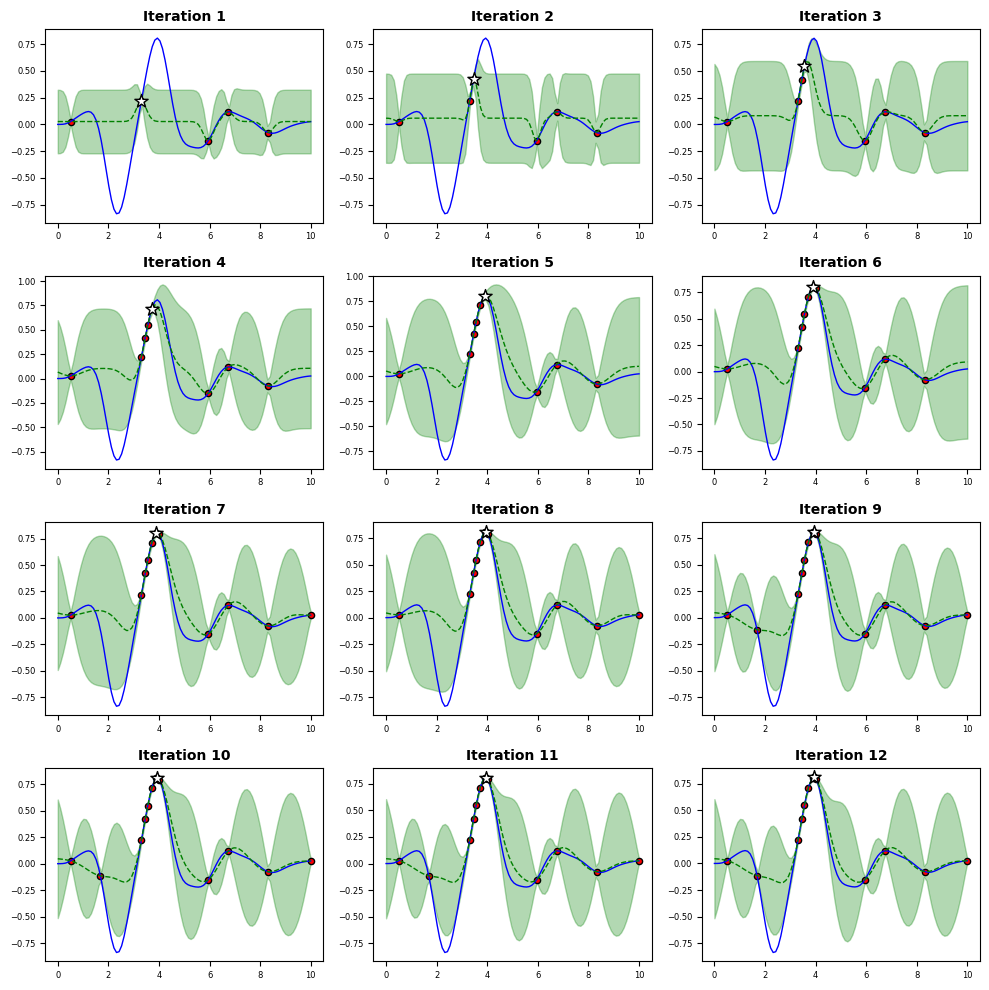

In [ ]:
def run_bayesian_optimization():
    # Setting parameters
    dim = 1
    bounds = torch.tensor([[0.0], [10.0]])
    n_initial = 5
    n_iterations = 12
    batch_size = 1

    # Create a grid for plotting
    x_values = np.linspace(0, 10, 100)
    X = torch.from_numpy(x_values.reshape(-1, 1)).float()
    Y = objective_function(X).numpy().reshape(-1, 1)

    # Initialise training data
    train_X = latin_hypercube_sampling(n_initial, dim, bounds)
    train_Y = objective_function(train_X).unsqueeze(-1)

    # Create figure and axes
    fig, axes = plt.subplots(4, 3, figsize=(10, 10))
    axes = axes.ravel()

    # Optimisation loop
    for i in range(n_iterations):
        # Fitting the model
        model = SingleTaskGP(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        # Plot on specific subplot 
        plot_bayesian_optimization(axes[i], train_X, train_Y, model, X, Y, iteration=i+1)

        # Acquisition function
        EI = LogExpectedImprovement(model=model, best_f=train_Y.max())

        # Optimise the acquisition function
        candidates, _ = optimize_acqf(
            acq_function=EI,
            bounds=bounds,
            q=batch_size,
            num_restarts=40,
            raw_samples=1024,
        )

        # Evaluate objective at new candidate point
        new_Y = objective_function(candidates).unsqueeze(-1)

        # Append new data to training data
        train_X = torch.cat([train_X, candidates])
        train_Y = torch.cat([train_Y, new_Y])

        # Print progress
        print(f"Iteration {i+1}: Best value so far: {train_Y.max().item()}")
        
    plt.tight_layout()
    plt.show()

# Run the optimisation
run_bayesian_optimization()

4.1.2 Progress of Constrained Bayesian Optimisation

Constraint function used in 4.1

In [28]:
# Defining the constraint 

def constraint_function(x):
    return torch.sin(1.8 * x) # sin(1.8x) <= 0

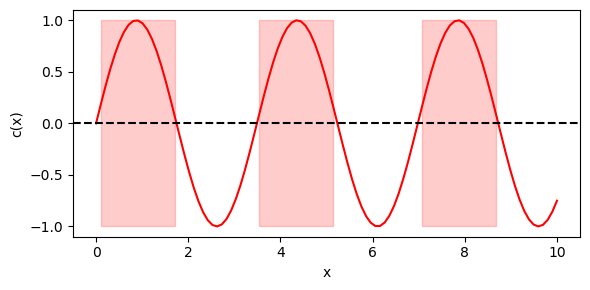

In [29]:
x = torch.linspace(0, 10, 100).unsqueeze(-1)
y = objective_function(x)
c = constraint_function(x)
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(x, c, 'r-', label='Constraint')
ax.axhline(y=0, color='k', linestyle='--')

ax.fill_between(x.squeeze(), c.min(), c.max(), 
                where=c.squeeze() > 0, 
                color='red', alpha=0.2, label='Infeasible Region')

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('c(x)', fontsize=10)

plt.tight_layout()
plt.show()

Progress of Constrained Bayesian Optimisation

In [30]:
def objective_function(x):
    return -torch.exp(-x) * x**3 * torch.cos(x) * torch.sin(x) * (torch.cos(x) * torch.sin(x)**2 - 1) # Salustowicz

In [31]:
# Setting up plot
def plot_bayesian_optimization(ax, train_X, train_Y, train_C, model, X, Y, C, iteration=None):
    
    ax.plot(X.numpy(), Y, 'b-', linewidth=1, label='Objective')
    
    with torch.no_grad():
        posterior = model.models[0].posterior(X)
        mean = posterior.mean.numpy()
        std = posterior.variance.sqrt().numpy()

    ax.plot(X.numpy(), mean, 'g--', linewidth=1, label='GP Mean')
    ax.fill_between(
        X.numpy().flatten(), 
        mean.flatten() - 2*std.flatten(), 
        mean.flatten() + 2*std.flatten(), 
        alpha=0.3, 
        color='green'
    )

    infeasible_mask = C > 0
    ax.fill_between(
        X.numpy().flatten(), 
        Y.min(), 
        Y.max(), 
        where=infeasible_mask.flatten(), 
        color='red', 
        alpha=0.2, 
        label='Infeasible Region'
    )

    feasible_mask = train_C.squeeze() <= 0
    ax.scatter(
        train_X[~feasible_mask].numpy(), 
        train_Y[~feasible_mask].numpy(), 
        color='red', 
        edgecolor='black',
        marker='o', 
        s=20  
    )
    ax.scatter(
        train_X[feasible_mask].numpy(), 
        train_Y[feasible_mask].numpy(), 
        color='green', 
        edgecolor='black',
        marker='o', 
        s=20  
    )
    if torch.any(feasible_mask):
        best_feasible_idx = torch.argmax(train_Y[feasible_mask])
        best_x = train_X[feasible_mask][best_feasible_idx]
        best_y = train_Y[feasible_mask][best_feasible_idx]
        ax.scatter(
            best_x.numpy(), 
            best_y.numpy(), 
            color='white', 
            edgecolor='black', 
            marker='*', 
            s=100,  
            zorder=10  
        )
    
    if iteration is not None:
        ax.set_title(f'Iteration {iteration}', fontsize=10, fontweight='bold')
    
    ax.tick_params(axis='both', which='major', labelsize=6)

Iteration 1: Best feasible value so far: -0.011937264671859677
Iteration 2: Best feasible value so far: 0.02434048760065153
Iteration 3: Best feasible value so far: 0.02434048760065153
Iteration 4: Best feasible value so far: 0.02434048760065153
Iteration 5: Best feasible value so far: 0.02434048760065153
Iteration 6: Best feasible value so far: 0.39121919251403653
Iteration 7: Best feasible value so far: 0.4430527755647558
Iteration 8: Best feasible value so far: 0.4587768540777541
Iteration 9: Best feasible value so far: 0.4587768540777541
Iteration 10: Best feasible value so far: 0.4587768540777541
Iteration 11: Best feasible value so far: 0.4587768540777541
Iteration 12: Best feasible value so far: 0.4587768540777541


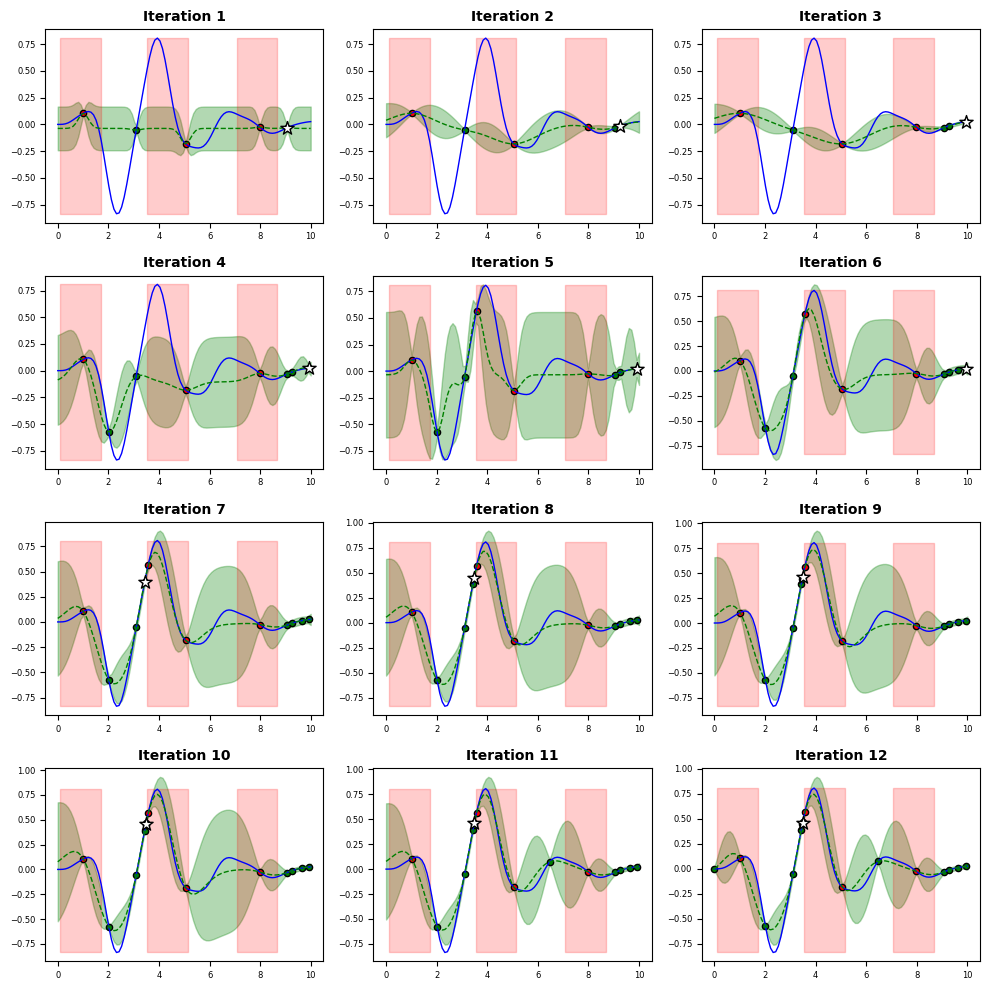

In [32]:
def run_bayesian_optimization():
    dim = 1
    bounds = torch.tensor([[0.0], [10.0]], dtype=torch.float64)  # Ensure bounds are float64
    n_initial = 5
    n_iterations = 12
    batch_size = 1

    x_values = np.linspace(0, 10, 100)
    
    X = torch.from_numpy(x_values.reshape(-1, 1)).float().double()
    Y = objective_function(X).numpy().reshape(-1, 1)
    C = constraint_function(X).numpy().reshape(-1, 1)
    
    train_X = latin_hypercube_sampling(n_initial, dim, bounds)
    train_Y = objective_function(train_X)
    train_C = constraint_function(train_X)

    fig, axes = plt.subplots(4, 3, figsize=(10, 10))
    axes = axes.ravel()  


    # Optimisation loop
    for i in range(n_iterations):
        model_obj = SingleTaskGP(train_X, train_Y)
        model_con = SingleTaskGP(train_X, train_C)
        model = ModelListGP(model_obj, model_con)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        plot_bayesian_optimization(axes[i], train_X, train_Y, train_C, model, X, Y, C, iteration=i+1)


        CEI = LogConstrainedExpectedImprovement(
            model=model,
            best_f=train_Y[train_C.squeeze() <= 0].max(),
            objective_index=0,
            constraints={1: (None, 0)},
        )
        candidates, _ = optimize_acqf(
            acq_function=CEI,
            bounds=bounds,
            q=batch_size,
            num_restarts=40,
            raw_samples=1024,
        )

        new_Y = objective_function(candidates)
        new_C = constraint_function(candidates)

        train_X = torch.cat([train_X, candidates])
        train_Y = torch.cat([train_Y, new_Y])
        train_C = torch.cat([train_C, new_C])

        print(f"Iteration {i+1}: Best feasible value so far: {train_Y[train_C.squeeze() <= 0].max().item()}")

    plt.tight_layout()
    plt.show()


run_bayesian_optimization()


4.1.3 Objective with No Clear Global Maximum

In [33]:
# Defining the objective 
def objective_function(x):
    return torch.sin(x[...,0]) # sin(x)

In [34]:
def plot_bayesian_optimization(ax, train_X, train_Y, model, X, Y, iteration, mean_sum, n_iterations, cmap='pink'):
    if iteration == 0:
        ax.plot(X.numpy(), Y, 'b-', linewidth=2)

    with torch.no_grad():
        posterior = model.posterior(X)
        mean = posterior.mean.numpy()
        std = posterior.variance.sqrt().numpy()

    mean_sum += mean

    if iteration == n_iterations - 1:
        avg_mean = mean_sum / n_iterations
        ax.plot(X.numpy(), avg_mean, '--', color='green', linewidth=2)

    # Use a colourmap to assign a unique color to each iteration
    cmap = colormaps[cmap]
    iteration_color = cmap(iteration / n_iterations)

    ax.fill_between(
        X.numpy().flatten(),
        mean.flatten() - 2 * std.flatten(),
        mean.flatten() + 2 * std.flatten(),
        alpha=0.3,
        color=iteration_color,
        label=f'GP Uncertainty (Iter {iteration + 1})'
    )

    ax.scatter(
        train_X.numpy(),
        train_Y.numpy(),
        facecolor='white',
        edgecolor='black',
        marker='o',
        s=30,
    )

    best_idx = torch.argmax(train_Y)
    best_x = train_X[best_idx]
    best_y = train_Y[best_idx]
    ax.scatter(
        best_x.numpy(),
        best_y.numpy(),
        facecolor='white',
        edgecolor='black',
        marker='*',
        s=120,
        zorder=10,
    )

    if iteration == n_iterations - 1:
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()



<Figure size 640x480 with 0 Axes>

Iteration 1: Best x value: 1.5879, Best y value: 0.9999
Iteration 2: Best x value: 1.5879, Best y value: 0.9999
Iteration 3: Best x value: 1.5879, Best y value: 0.9999
Iteration 4: Best x value: 1.5879, Best y value: 0.9999
Iteration 5: Best x value: 7.8568, Best y value: 1.0000
Iteration 6: Best x value: 7.8568, Best y value: 1.0000
Iteration 7: Best x value: 7.8568, Best y value: 1.0000
Iteration 8: Best x value: 7.8568, Best y value: 1.0000
Iteration 9: Best x value: 7.8568, Best y value: 1.0000
Iteration 10: Best x value: 1.5683, Best y value: 1.0000
Iteration 11: Best x value: 1.5711, Best y value: 1.0000
Iteration 12: Best x value: 1.5711, Best y value: 1.0000


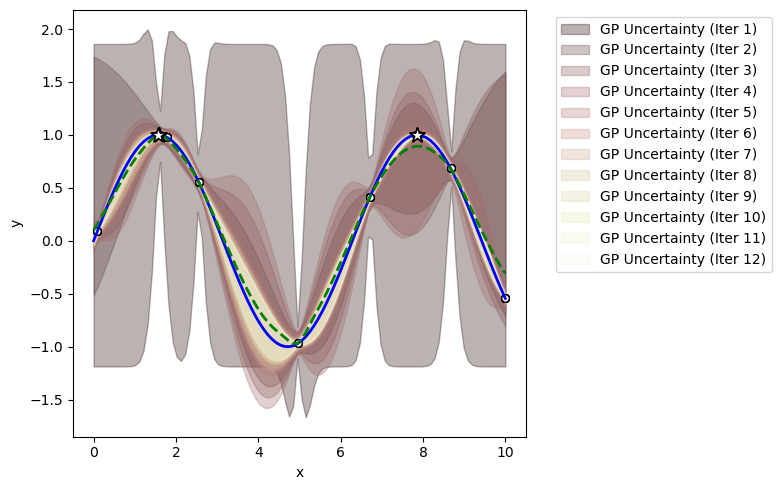

In [36]:
def run_bayesian_optimization():
    dim = 1
    bounds = torch.tensor([[0.0], [10.0]])
    n_initial = 5
    n_iterations = 12
    batch_size = 1

    x_values = np.linspace(0, 10, 100)
    X = torch.from_numpy(x_values.reshape(-1, 1)).float()
    Y = objective_function(X).numpy().reshape(-1, 1)

    train_X = latin_hypercube_sampling(n_initial, dim, bounds)
    train_Y = objective_function(train_X).unsqueeze(-1)

    fig, ax = plt.subplots(figsize=(8, 5))
    mean_sum = np.zeros_like(Y)

    for i in range(n_iterations):
        model = SingleTaskGP(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        plot_bayesian_optimization(ax, train_X, train_Y, model, X, Y, i, mean_sum, n_iterations)

        EI = LogExpectedImprovement(model=model, best_f=train_Y.max())

        candidates, _ = optimize_acqf(
            acq_function=EI,
            bounds=bounds,
            q=batch_size,
            num_restarts=40,
            raw_samples=1024,
        )

        new_Y = objective_function(candidates).unsqueeze(-1)

        train_X = torch.cat([train_X, candidates])
        train_Y = torch.cat([train_Y, new_Y])

        best_idx = torch.argmax(train_Y)
        best_x = train_X[best_idx].item()
        best_y = train_Y[best_idx].item()

        print(f"Iteration {i + 1}: Best x value: {best_x:.4f}, Best y value: {best_y:.4f}")

    plt.tight_layout()
    plt.show()


run_bayesian_optimization()